In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from src.settings import *
import pickle as pkl
import gzip
from src.tools.vis_utils import VisualizationConfig, FIGSIZE, visualize_dendrogram, plot_hexagons_map, plot_clusters, ensure_geometry_type
from src.tools.dim_reduction import reduce_umap, reduce_tsne
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import dataclasses
import json5 as json
from scipy.cluster.hierarchy import cut_tree
from src.tools.configs import ExperimentConfig
from src.tools.clustering import remap_cluster
from src.tools.feature_extraction import features_wide_to_long
from sklearn.metrics import pairwise_distances, pairwise_distances_argmin
from tqdm.auto import tqdm
import seaborn as sns
import plotly.express as px
import numpy as np
from IPython.display import display
import contextily as ctx
import operator
from src.tools.vis_utils import visualize_kepler, save_config


In [3]:
run_name = "rose-sun-44"
# run_name = "worldly-pine-46"
# run_name = "autumn-thunder-48"
# run_name = "zesty-microwave-49"
run_dir = RUNS_DATA_DIR / run_name

In [4]:
with open(run_dir / "experiment_config.json", "r") as f:
    ec_json = json.load(f)
    ec = ExperimentConfig(**ec_json)
ec

ExperimentConfig(dataset_filename='dataset_2022-01-04_20-41-53_poland.pkl.gz', model_name='autoencoder', mode='edges', test_cities=[], test_size=0.2, random_seed=42, batch_size=200, num_workers=3, shuffle=True, hidden_dim=64, enc_out_dim=40, latent_dim=30, epochs=50, kl_coeff=0.1, lr=0.001)

In [5]:
vc = VisualizationConfig(
    n_clusters=None,
    distance_threshold=0,
    affinity="euclidean",
    linkage="ward",
    truncate_mode="level",
    p=3,
    clusters=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    # clusters=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    cities_to_plot=["Wrocław", "Bydgoszcz", "Trójmiasto", "Warszawa", "Kraków", "Poznań"],
    # cities_to_plot=["Wrocław"],
    countries_subsample=["Poland", "Germany"],
    umap_n_components=2,
    umap_n_neighbours=30,
    umap_metric="euclidean",
    tsne_perplexity=100,
)

vis_dir = run_dir / "vis"
vis_dir.mkdir(parents=True, exist_ok=True)

with open(vis_dir / "vis_config.json", "w") as f:
    json.dump(dataclasses.asdict(vc), f, indent=2, quote_keys=True, trailing_commas=False)

In [18]:
with gzip.open(run_dir / "dataset.pkl.gz", "rb") as f:
    ds = pkl.load(f)

z_df = pd.read_pickle(run_dir / "embeddings.pkl.gz")
input_df = pd.read_pickle(run_dir / "input.pkl.gz")

if ec.mode == "edges":
    z_df_edges = z_df
    z_df = z_df.groupby(level=[0, 1, 2, 3]).mean()

    input_df_edges = input_df
    input_df = input_df.groupby(level=[0, 1, 2, 3]).sum()
    input_df_mean = input_df_edges.groupby(level=[0, 1, 2, 3]).mean()

z_df_scaled = pd.DataFrame(StandardScaler().fit_transform(z_df), index=z_df.index, columns=z_df.columns)
z_df_scaled_cosine = pd.DataFrame(StandardScaler(with_std=False).fit_transform(z_df), index=z_df.index, columns=z_df.columns)
hexagons = ds.hexagons

In [7]:
ds.__annotations__

{'config': src.tools.configs.DatasetGenerationConfig,
 'cities': pandas.core.frame.DataFrame,
 'edges': geopandas.geodataframe.GeoDataFrame,
 'edges_feature_selected': geopandas.geodataframe.GeoDataFrame,
 'hexagons': geopandas.geodataframe.GeoDataFrame,
 'hex_agg': typing.Optional[pandas.core.frame.DataFrame],
 'hex_agg_normalized': typing.Optional[pandas.core.frame.DataFrame]}

In [8]:
countries_subsample = vc.countries_subsample

z_df = z_df.loc[(slice(None), countries_subsample), :]
z_df_scaled = z_df_scaled.loc[(slice(None), countries_subsample), :]
z_df_scaled_cosine = z_df_scaled_cosine.loc[(slice(None), countries_subsample), :]
z_df_edges = z_df_edges.loc[(slice(None), countries_subsample), :]
ds.edges = ds.edges.loc[(slice(None), countries_subsample), :]
ds.edges_feature_selected = ds.edges_feature_selected.loc[(slice(None), countries_subsample), :]
input_df = input_df.loc[(slice(None), countries_subsample), :]
input_df_edges = input_df_edges.loc[(slice(None), countries_subsample), :]
input_df_mean = input_df_mean.loc[(slice(None), countries_subsample), :]
ds.hexagons = ds.hexagons.loc[(slice(None), countries_subsample), :]

In [9]:
unique_cities_df = z_df.reset_index(level=[0, 1, 3], drop=True).index.unique()
print("Cities:", unique_cities_df.size)
unique_cities_df

Cities: 13


Index(['Białystok', 'Bydgoszcz', 'Częstochowa', 'Kraków', 'Lublin', 'Poznań',
       'Radom', 'Szczecin', 'Trójmiasto', 'Warszawa', 'Wrocław',
       'Zielona Góra', 'Łódź'],
      dtype='object', name='city')

In [10]:
z_df

z_0       z_1       z_2  \
continent country city      h3_id                                           
Europe    Poland  Białystok 891f5104d23ffff  0.105459  0.485647  0.060334   
                            891f5104d2bffff  0.462417  0.338800  0.026129   
                            891f5104d37ffff  0.250927  0.186240 -0.069000   
                            891f5104da7ffff  0.451818  0.111140  0.251220   
                            891f5104db7ffff  0.138427  0.208027  0.214268   
...                                               ...       ...       ...   
                  Łódź      891f5249ba7ffff  0.361085 -0.114209 -0.184200   
                            891f5249babffff  0.393954  0.023222 -0.123309   
                            891f5249bafffff  0.346834 -0.047206 -0.119023   
                            891f5249bb3ffff  0.328914 -0.017214 -0.124593   
                            891f5249bb7ffff  0.338041 -0.071825 -0.140928   

                                                  z_3       z_4       z_5  \
continent country city      h3_id                                           
Europe    Poland  Białystok 891f5104d23ffff -0.085838 -0.446157  0.078250   
                            891f5104d2bffff -0.047096 -0.412656  0.413347   
                            891f5104d37ffff -0.242506 -0.346692  0.179084   
                            891f5104da7ffff -0.233724 -0.099736 -0.049473   
                            891f5104db7ffff -0.059154 -0.082445 -0.019271   
...                                               ...       ...       ...   
                  Łódź      891f5249ba7ffff  0.017465 -0.423862 -0.164949   
                            891f5249babffff  0.042827 -0.232701 -0.299262   
                            891f5249bafffff  0.081171 -0.252411 -0.310986   
                            891f5249bb3ffff  0.080854 -0.246402 -0.311647   
                            891f5249bb7ffff  0.032799 -0.112352 -0.348310   

                                                  z_6       z_7       z_8  \
continent country city      h3_id                                           
Europe    Poland  Białystok 891f5104d23ffff -0.417931  0.616665 -0.234479   
                            891f5104d2bffff -0.280526  0.056869 -0.364861   
                            891f5104d37ffff -0.249456  0.811066 -0.205631   
                            891f5104da7ffff -0.271298  0.076505  0.009673   
                            891f5104db7ffff -0.344104 -0.113428  0.172007   
...                                               ...       ...       ...   
                  Łódź      891f5249ba7ffff -0.577549 -0.000061  0.161067   
                            891f5249babffff -0.623875  0.107879  0.180608   
                            891f5249bafffff -0.591664  0.003025  0.139568   
                            891f5249bb3ffff -0.595778  0.018937  0.141503   
                            891f5249bb7ffff -0.597613  0.073482  0.218673   

                                                  z_9  ...      z_20  \
continent country city      h3_id                      ...             
Europe    Poland  Białystok 891f5104d23ffff -0.015324  ... -0.583364   
                            891f5104d2bffff -0.195521  ... -0.111303   
                            891f5104d37ffff  0.118934  ... -0.897902   
                            891f5104da7ffff -0.030250  ... -0.226087   
                            891f5104db7ffff -0.177396  ... -0.188112   
...                                               ...  ...       ...   
                  Łódź      891f5249ba7ffff  0.271538  ... -0.080928   
                            891f5249babffff  0.306637  ... -0.071756   
                            891f5249bafffff  0.276762  ... -0.029629   
                            891f5249bb3ffff  0.268272  ... -0.039156   
                            891f5249bb7ffff  0.386854  ... -0.069442   

                                                 z_21      z_22      z_23  \
continent country city      h3

In [11]:
feature_keys = list(ds.config.featureset_selection["features"].keys())
feature_keys

['oneway',
 'lanes',
 'highway',
 'maxspeed',
 'bridge',
 'access',
 'junction',
 'width',
 'tunnel',
 'surface']

In [12]:
edges_fs_long = features_wide_to_long(ds.edges_feature_selected.assign(geometry=ds.edges["geometry"]), feature_keys)
edges_fs_long

geometry  \
continent country city      h3_id                                                                
Europe    Poland  Białystok 891f5106993ffff  LINESTRING (23.10751 53.14003, 23.10740 53.139...   
                            891f5106993ffff  LINESTRING (23.10751 53.14003, 23.10728 53.140...   
                            891f5106d67ffff  LINESTRING (23.10751 53.14003, 23.10728 53.140...   
                            891f5106997ffff  LINESTRING (23.10817 53.13987, 23.10799 53.139...   
                            891f5106993ffff  LINESTRING (23.10817 53.13987, 23.10799 53.139...   
...                                                                                        ...   
                  Łódź      891e2186aafffff  LINESTRING (19.35522 51.79957, 19.35516 51.798...   
                            891e2186a33ffff  LINESTRING (19.35522 51.79957, 19.35516 51.798...   
                            891e2186a33ffff  LINESTRING (19.35423 51.79942, 19.35436 51.799...   
                            891e2186a33ffff  LINESTRING (19.35423 51.79942, 19.35522 51.79957)   
                            891e2186aafffff  LINESTRING (19.35423 51.79942, 19.35522 51.79957)   

                                                   oneway    lanes  \
continent country city      h3_id                                    
Europe    Poland  Białystok 891f5106993ffff   oneway_True  lanes_5   
                            891f5106993ffff   oneway_True  lanes_2   
                            891f5106d67ffff   oneway_True  lanes_2   
                            891f5106997ffff   oneway_True  lanes_4   
                            891f5106993ffff   oneway_True  lanes_4   
...                                                   ...      ...   
                  Łódź      891e2186aafffff  oneway_False      NaN   
                            891e2186a33ffff  oneway_False      NaN   
                            891e2186a33ffff  oneway_False      NaN   
                            891e2186a33ffff  oneway_False      NaN   
                            891e2186aafffff  oneway_False      NaN   

                                                         highway     maxspeed  \
continent country city      h3_id                                               
Europe    Poland  Białystok 891f5106993ffff    highway_secondary  maxspeed_50   
                            891f5106993ffff    highway_secondary  maxspeed_50   
                            891f5106d67ffff    highway_secondary  maxspeed_50   
                            891f5106997ffff    highway_secondary  maxspeed_50   
                            891f5106993ffff    highway_secondary  maxspeed_50   
...                                                          ...          ...   
                  Łódź      891e2186aafffff  highway_residential          NaN   
                            891e2186a33ffff  highway_residential          NaN   
                            891e2186a33ffff  highway_residential          NaN   
                            891e2186a33ffff  highway_residential          NaN   
                            891e2186aafffff  highway_residential          NaN   

                                            bridge access junction width  \
continent country city      h3_id                                          
Europe    Poland  Białystok 891f5106993ffff    NaN    NaN      NaN   NaN   
                            891f5106993ffff    NaN    NaN      NaN   NaN   
                            891f5106d67ffff    NaN    NaN      NaN   NaN   
                            891f5106997ffff    NaN    NaN      NaN   NaN   
                            891f5106993ffff    NaN    NaN      NaN   NaN   
...                                            ...    ...      ...   ...   
                  Łódź      891e2186aafffff    NaN    NaN      NaN   NaN   
                            891e2186a33ffff    NaN    NaN      NaN   NaN   
                            891e2186a33ffff    NaN    NaN      NaN   NaN   
          

In [13]:
input_df_profile = input_df.copy()
for f_k in feature_keys:
        features_for_key = [x for x in input_df.columns if f_k in x]
        input_df_profile[features_for_key] = input_df_profile[features_for_key].apply(lambda x: x / x.sum(), axis=1)

input_df_profile

oneway_False  oneway_True  \
continent country city      h3_id                                        
Europe    Poland  Białystok 891f5104d23ffff      0.000000     1.000000   
                            891f5104d2bffff      0.000000     1.000000   
                            891f5104d37ffff      0.000000     1.000000   
                            891f5104da7ffff      0.142857     0.857143   
                            891f5104db7ffff      0.285714     0.714286   
...                                                   ...          ...   
                  Łódź      891f5249ba7ffff      1.000000     0.000000   
                            891f5249babffff      1.000000     0.000000   
                            891f5249bafffff      1.000000     0.000000   
                            891f5249bb3ffff      1.000000     0.000000   
                            891f5249bb7ffff      1.000000     0.000000   

                                             lanes_1   lanes_2   lanes_3  \
continent country city      h3_id                                          
Europe    Poland  Białystok 891f5104d23ffff      0.0  0.500000  0.500000   
                            891f5104d2bffff      0.4  0.400000  0.200000   
                            891f5104d37ffff      0.0  0.500000  0.500000   
                            891f5104da7ffff      0.0  0.833333  0.166667   
                            891f5104db7ffff      0.0  0.750000  0.250000   
...                                              ...       ...       ...   
                  Łódź      891f5249ba7ffff      NaN       NaN       NaN   
                            891f5249babffff      NaN       NaN       NaN   
                            891f5249bafffff      NaN       NaN       NaN   
                            891f5249bb3ffff      NaN       NaN       NaN   
                            891f5249bb7ffff      NaN       NaN       NaN   

                                             lanes_4  lanes_5  lanes_6  \
continent country city      h3_id                                        
Europe    Poland  Białystok 891f5104d23ffff      0.0      0.0      0.0   
                            891f5104d2bffff      0.0      0.0      0.0   
                            891f5104d37ffff      0.0      0.0      0.0   
                            891f5104da7ffff      0.0      0.0      0.0   
                            891f5104db7ffff      0.0      0.0      0.0   
...                                              ...      ...      ...   
                  Łódź      891f5249ba7ffff      NaN      NaN      NaN   
                            891f5249babffff      NaN      NaN      NaN   
                            891f5249bafffff      NaN      NaN      NaN   
                            891f5249bb3ffff      NaN      NaN      NaN   
                            891f5249bb7ffff      NaN      NaN      NaN   

                                             lanes_7  lanes_8  ...  \
continent country city      h3_id                              ...   
Europe    Poland  Białystok 891f5104d23ffff      0.0      0.0  ...   
                            891f5104d2bffff      0.0      0.0  ...   
                            891f5104d37ffff      0.0      0.0  ...   
                            891f5104da7ffff      0.0      0.0  ...   
                            891f5104db7ffff      0.0      0.0  ...   
...                                              ...      ...  ...   
                  Łódź      891f5249ba7ffff      NaN      NaN  ...   
                            891f5249babffff      NaN      NaN  ...   
                            891f5249bafffff      NaN      NaN  ...   
                            891f5249bb3ffff      NaN      NaN  ...   
                            891f5249bb7ffff      NaN      NaN  ...   

                                             width_20.0  \
continent country city      h3_id                         
Europe    Poland  Białystok 891f5104d23ffff         NaN   
                            891f5104d2bfff

In [14]:
def get_hex_profile(hex_id: str) -> pd.Series:
    hex_profile = input_df_profile.loc[(slice(None), slice(None), slice(None), hex_id)] \
        .iloc[0] \
        .sort_values(ascending=False)

    return hex_profile[hex_profile > 0]

In [13]:
ac_model = AgglomerativeClustering(n_clusters=vc.n_clusters, distance_threshold=vc.distance_threshold, affinity=vc.affinity, linkage=vc.linkage)
ac_model.fit(z_df_scaled)
# ac_model = AgglomerativeClustering(n_clusters=vc.n_clusters, distance_threshold=vc.distance_threshold, affinity="cosine", linkage="average")  # use with_std=False in StandardScaler
# ac_model.fit(z_df_scaled_cosine)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

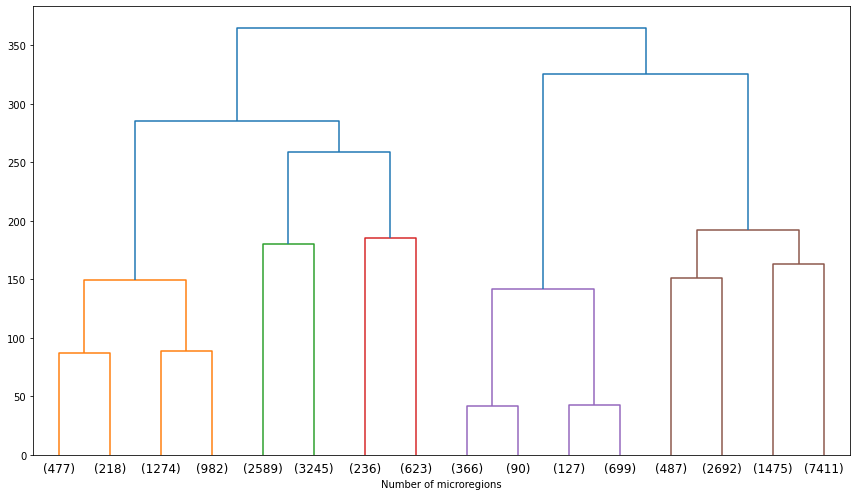

In [15]:
dendrogram_path = vis_dir / "dendrogram.png"

fig, ax = plt.subplots(figsize=(12, 7))
# plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel("Number of microregions")

linkage_matrix = visualize_dendrogram(ac_model, truncate_mode=vc.truncate_mode, p=vc.p, ax=ax)

plt.tight_layout()
fig.savefig(dendrogram_path, facecolor='w')
plt.show()

In [16]:

z_df_with_clusters = z_df.copy()
cut_tree_results = cut_tree(linkage_matrix, n_clusters = vc.clusters)
clusters_divided = [None]
for index, c in tqdm(list(enumerate(vc.clusters))):
    assigned_clusters = cut_tree_results[:, index]
    z_df_with_clusters[f"cluster_{c}"] = pd.Series(assigned_clusters, index=z_df.index).astype("category")

    if index > 0:
        remapped_clusters, cluster_divided_id = remap_cluster(z_df_with_clusters, c=c)
        clusters_divided.append(cluster_divided_id)
        z_df_with_clusters[f"cluster_{c}"] = remapped_clusters

hexagons_clustered = hexagons.join(z_df_with_clusters[[f"cluster_{c}" for c in vc.clusters]]).dropna().set_crs(epsg=4326)
# hexagons_clustered.head(3)

100%|██████████| 11/11 [00:00<00:00, 50.29it/s]


In [17]:
df_clusters = z_df_with_clusters[[f"cluster_{c}" for c in vc.clusters]]
df_clusters.to_pickle(vis_dir / "clusters.pkl.gz")

import csv
with open(vis_dir / "clusters_divided.csv", "w") as f:
    write = csv.writer(f)
    write.writerow(clusters_divided)

In [20]:
edges_keplergl = edges_fs_long.astype(str)

In [99]:
config_name = "edges_hexes"

hexagons_keplergl = hexagons_clustered.reset_index().drop(columns=["coordinates", "parent", "children"])
hexagons_keplergl["h3_id"] = hexagons_keplergl["h3_id"].map(lambda x: f"hex_{x}")


m = visualize_kepler(data={
        "edges": edges_keplergl,
        "hexagons": hexagons_keplergl,
    }, 
    config_name=config_name)
m

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'hs22789', 'type': …

In [19]:
save_config(m, config_name=config_name)

WindowsPath('D:/Projekty/Programowanie/Studia/Semestr10/gis/osm-road-infrastructure/assets/keplergl/config/edges_hexes.json')

In [20]:
# from src.tools.vis_utils import save_kepler_map
# save_kepler_map(m, config_name)

In [20]:
hexagons_dir = vis_dir / "hexagons"
hexagons_dir.mkdir(parents=True, exist_ok=True)
for ctp in tqdm(vc.cities_to_plot):
    for idx, c in enumerate(vc.clusters):
        cluster_divided_id = clusters_divided[idx]
        # ax = plot_hexagons_map(hexagons_clustered.loc[:, :, ctp], ds.edges.loc[:, :, ctp], f"cluster_{c}", title=f"Division on cluster {cluster_divided_id} to {cluster_divided_id} and {c - 1}" if cluster_divided_id is not None else "Initial division")
        ax = plot_hexagons_map(hexagons_clustered.loc[:, :, ctp], ds.edges.loc[:, :, ctp], f"cluster_{c}", title="")
        ax.set_axis_off()
        plt.tight_layout()
        plt.savefig(hexagons_dir / f"{ctp}_cluster_{c}.png", facecolor='w', dpi=100)
        plt.close()
        # print(f"Division on cluster {cluster_divided_id} to {cluster_divided_id} and {c - 1}" if cluster_divided_id is not None else "Initial division")

100%|██████████| 6/6 [03:42<00:00, 37.11s/it]


In [21]:
# umap_dir = vis_dir / "umap"
# umap_dir.mkdir(parents=True, exist_ok=True)
# z_df_umaped = reduce_umap(z_df_scaled, n_components=vc.umap_n_components, n_neighbors=vc.umap_n_neighbours, metric=vc.umap_metric)[0]
# for idx, c in enumerate(vc.clusters):
#     cluster_divided_id = clusters_divided[idx]
#     cluster_to_show = f"cluster_{c}"
#     z_df_umaped["cluster"] = z_df_with_clusters[cluster_to_show]
#     fig = plot_clusters(z_df_umaped, title=f"Division on cluster {cluster_divided_id} to {cluster_divided_id} and {c - 1}")
#     fig.write_image(umap_dir / f"umap_hexes_{c}.png")

In [21]:
z_df_tsned = reduce_tsne(z_df_scaled, n_components=vc.umap_n_components, perplexity=vc.tsne_perplexity)

In [24]:
tsne_dir = vis_dir / "tsne"
tsne_dir.mkdir(parents=True, exist_ok=True)
# for idx, c in enumerate(vc.clusters):
for idx, c in enumerate([8]):
    cluster_divided_id = clusters_divided[idx]
    cluster_to_show = f"cluster_{c}"
    z_df_tsned["cluster"] = z_df_with_clusters[cluster_to_show]
    # fig = plot_clusters(z_df_tsned.sort_values("cluster"), title=f"Division on cluster {cluster_divided_id} to {cluster_divided_id} and {c - 1}" if cluster_divided_id is not None else "Initial division")
    fig = plot_clusters(z_df_tsned.sort_values("cluster"), title="")
    # fig.write_image(tsne_dir / f"tsne_hexes_{c}.png")
    fig.show()

In [15]:
def hex_diff(z_df, hex_id_1, hex_id_2, operator_func, metric, city=None, top_n=5):
    hex_1_z = z_df.loc[(slice(None), slice(None), slice(None), hex_id_1), :]
    hex_2_z = z_df.loc[(slice(None), slice(None), slice(None), hex_id_2), :]
    hex_diff_z = operator_func(hex_1_z.values, hex_2_z.values).reshape(1, -1)

    if city is None:
        df = z_df
    else: 
        df = z_df.loc[(slice(None), slice(None), city), :]

    # hex_diff_closest_id = pairwise_distances_argmin(df, hex_diff_z, axis=0, metric=metric).item()
    # hex_diff_closest = df.iloc[[hex_diff_closest_id]]

    hex_diff_closest_ids = pairwise_distances(df, hex_diff_z, metric=metric).argsort(axis=0)[:top_n].squeeze()
    hex_diff_closest = df.iloc[np.array([hex_diff_closest_ids]).reshape(-1,)]

    hex_1 = input_df.loc[hex_1_z.index].assign(diff="first").assign(top_n=0)
    hex_2 = input_df.loc[hex_2_z.index].assign(diff="second").assign(top_n=0)
    hex_diff = input_df.loc[hex_diff_closest.index].assign(diff="diff").assign(top_n=list(range(top_n))).drop(hex_1.index, errors="ignore").drop(hex_2.index, errors="ignore")

    diff_gdf = gpd.GeoDataFrame(pd.concat([hex_1, hex_2, hex_diff], axis=0).join(hexagons["geometry"]), crs="EPSG:4326")
    # diff_gdf["diff"] = pd.Series(["first", "second"] + (["diff"] * len(hex_diff)), index=diff_gdf.index)

    return diff_gdf

def hex_interp(z_df, hex_start_id, hex_end_id, metric, city=None, n_steps=20):
    z_start = z_df.loc[(slice(None), slice(None), slice(None), hex_start_id), :]
    z_end = z_df.loc[(slice(None), slice(None), slice(None), hex_end_id), :]
    hex_start = input_df.loc[z_start.index].assign(type="start").assign(step=0)
    hex_end = input_df.loc[z_end.index].assign(type="end").assign(step=0)


    if city is None:
        df = z_df
    else: 
        df = z_df.loc[(slice(None), slice(None), city), :]
    steps = np.linspace(z_start, z_end, n_steps)
    hexes_steps = pd.DataFrame()
    for idx, step in enumerate(steps): 

        hex_diff_closest_id = pairwise_distances_argmin(df, step, axis=0, metric=metric).item()
        hex_diff_closest = df.iloc[[hex_diff_closest_id]]

        
        hex_step = input_df.loc[hex_diff_closest.index]
        hexes_steps = pd.concat([hexes_steps, hex_step], axis=0)
    hexes_steps = hexes_steps.drop_duplicates().drop(hex_start.index, errors="ignore").drop(hex_end.index, errors="ignore")
    hexes_steps = hexes_steps.assign(type="diff").assign(step=list(range(hexes_steps.shape[0])))

    steps_final = pd.concat([hex_start, hexes_steps, hex_end], axis=0)
    steps_final = features_wide_to_long(steps_final, feature_keys)
    steps_final = gpd.GeoDataFrame(steps_final.join(hexagons["geometry"]), crs="EPSG:4326")
    return steps_final


vis_operations_dir = vis_dir / "operations"
vis_operations_dir.mkdir(parents=True, exist_ok=True)

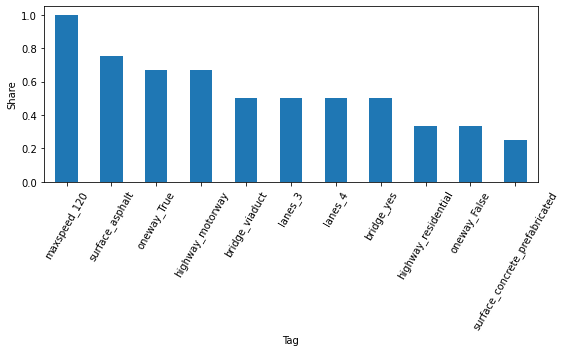

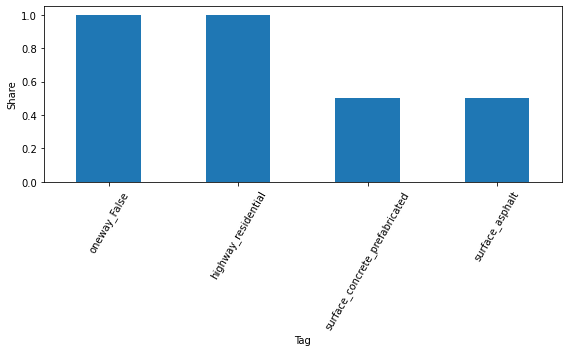

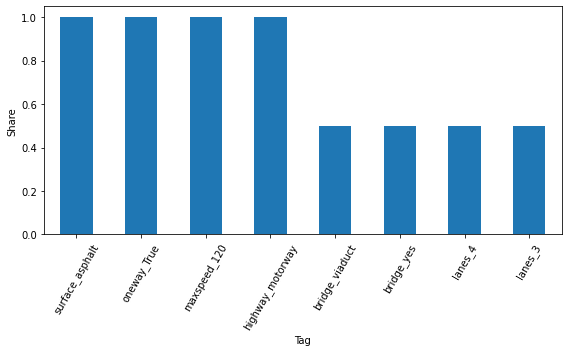

In [16]:
def plot_hex_profile(hex_profile: pd.Series) -> plt.Axes:
    ax = hex_profile.plot(kind="bar", figsize=(8, 5))
    plt.xticks(rotation=60)
    plt.xlabel("Tag")
    plt.ylabel("Share")
    plt.tight_layout()
    return ax


hex_profile_ids = ["891e2042167ffff", "891e2042177ffff", "891e2042edbffff"]
for hex_profile_id in hex_profile_ids:
    hex_profile = get_hex_profile(hex_profile_id)
    plot_hex_profile(hex_profile)
    plt.savefig(vis_operations_dir / f"hex_{hex_profile_id}_profile.png", facecolor='w')
    plt.show()


In [21]:
hex_id_first = "891e2042167ffff"
hex_id_second = "891e2042177ffff"
operator_func = operator.sub

# hex_id_first = "891e2047243ffff"
# hex_id_second = "891e2045483ffff"
# operator_func = operator.add

top_n = 1
city = "Wrocław"

diff_gdf = hex_diff(z_df_scaled_cosine, hex_id_first, hex_id_second, operator_func, metric="cosine", city=city, top_n=top_n)
# diff_gdf = hex_diff(z_df_scaled, hex_id_first, hex_id_second, operator_func, metric="euclidean", city=city, top_n=top_n)
unique_cities_in_diff = diff_gdf.index.droplevel(3).unique()
display(unique_cities_in_diff)

diff_gdf = diff_gdf.reset_index()
diff_gdf["h3_id"] = diff_gdf["h3_id"].map(lambda x: f"hex_{x}")
config_name = "hex_diff"
m = visualize_kepler(data={
        "edges": edges_keplergl.droplevel(3).loc[unique_cities_in_diff],
        "diff": diff_gdf.copy(),
    }, 
    config_name=config_name)
m

MultiIndex([('Europe', 'Poland', 'Wrocław')],
           names=['continent', 'country', 'city'])

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'a1fkfls', 'type': …

In [26]:
save_config(m, config_name=config_name)

WindowsPath('D:/Projekty/Programowanie/Studia/Semestr10/gis/osm-road-infrastructure/assets/keplergl/config/hex_diff.json')

In [103]:
start_h3_id = "891e2043117ffff"
# end_h3_id = "891e2047243ffff"
end_h3_id = "891e204011bffff"

city = "Wrocław"
n_steps = 5

metric = "euclidean"
df = z_df_scaled

# metric = "cosine"
# df = z_df_scaled_cosine

steps_final = hex_interp(df, start_h3_id, end_h3_id, metric=metric, city=city, n_steps=n_steps)

unique_cities_in_steps = steps_final.index.droplevel(3).unique()
display(unique_cities_in_steps)
display(steps_final)
steps_final = steps_final.reset_index()
steps_final["h3_id"] = steps_final["h3_id"].map(lambda x: f"hex_{x}")
config_name = "hex_interp"
m = visualize_kepler(data={
        "edges": edges_keplergl.droplevel(3).loc[unique_cities_in_steps],
        "diff": steps_final.copy(),
    }, 
    config_name=config_name)
m

MultiIndex([('Europe', 'Poland', 'Wrocław')],
           names=['continent', 'country', 'city'])

type  step        oneway    lanes  \
continent country city    h3_id                                                 
Europe    Poland  Wrocław 891e2043117ffff  start     0  oneway_False      NaN   
                          891e204190bffff   diff     0  oneway_False  lanes_2   
                          891e20405d3ffff   diff     1   oneway_True  lanes_2   
                          891e20401cfffff   diff     2   oneway_True  lanes_2   
                          891e204011bffff    end     0   oneway_True  lanes_1   

                                                         highway     maxspeed  \
continent country city    h3_id                                                 
Europe    Poland  Wrocław 891e2043117ffff    highway_residential  maxspeed_30   
                          891e204190bffff  highway_living_street  maxspeed_50   
                          891e20405d3ffff        highway_primary  maxspeed_60   
                          891e20401cfffff        highway_primary  maxspeed_60   
                          891e204011bffff        highway_primary  maxspeed_40   

                                                   bridge access junction  \
continent country city    h3_id                                             
Europe    Poland  Wrocław 891e2043117ffff             NaN    NaN      NaN   
                          891e204190bffff      bridge_yes    NaN      NaN   
                          891e20405d3ffff  bridge_viaduct    NaN      NaN   
                          891e20401cfffff  bridge_viaduct    NaN      NaN   
                          891e204011bffff  bridge_viaduct    NaN      NaN   

                                          width tunnel          surface  \
continent country city    h3_id                                           
Europe    Poland  Wrocław 891e2043117ffff   NaN    NaN              NaN   
                          891e204190bffff   NaN    NaN  surface_asphalt   
                          891e20405d3ffff   NaN    NaN  surface_asphalt   
                          891e20401cfffff   NaN    NaN  surface_asphalt   
                          891e204011bffff   NaN    NaN  surface_asphalt   

                                                                                    geometry  
continent country city    h3_id                                                               
Europe    Poland  Wrocław 891e2043117ffff  POLYGON ((16.88854 51.13531, 16.88858 51.13363...  
                          891e204190bffff  POLYGON ((16.99051 51.06267, 16.99055 51.06099...  
                          891e20405d3ffff  POLYGON ((16.94114 51.13945, 16.94118 51.13777...  
                          891e20401cfffff  POLYGON ((16.96422 51.11743, 16.96426 51.11575...  
                          891e204011bffff  POLYGON ((16.96924 51.11759, 16.96927 51.11590...

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


d:\Projekty\Programowanie\Studia\Semestr10\gis\osm-road-infrastructure\venv\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'a1fkfls', 'type': …

In [28]:
save_config(m, config_name=config_name)

WindowsPath('D:/Projekty/Programowanie/Studia/Semestr10/gis/osm-road-infrastructure/assets/keplergl/config/hex_interp.json')

In [38]:
def cluster_difference(df_mean, first_cluster, second_cluster):
    return (df_mean.loc[first_cluster] - df_mean.loc[second_cluster]).sort_values(ascending=False)

vis_features_dir = vis_dir / "features"

for idx, c in tqdm(list(enumerate(vc.clusters))):
    c_name = f"cluster_{c}"
    input_df_cluster_mean = input_df_mean.groupby(df_clusters[c_name]).mean()


    # input_df_cluster_mean_perc = input_df_cluster_mean.apply(lambda x: x / x.sum())  # or
    input_df_cluster_mean_perc = input_df_cluster_mean.copy()
    for f_k in feature_keys:
        features_for_key = [x for x in input_df_cluster_mean_perc.columns if f_k in x]
        input_df_cluster_mean_perc[features_for_key] = input_df_cluster_mean_perc[features_for_key].apply(lambda x: x / x.sum(), axis=1)


    vis_features_cluster_dir = vis_features_dir / c_name
    vis_features_cluster_dir.mkdir(parents=True, exist_ok=True)


    features_wide_to_long(input_df_cluster_mean_perc, feature_keys).T.to_csv(vis_features_cluster_dir / "clusters_characteristics.csv")


    cluster_divided_id = clusters_divided[idx]
    if cluster_divided_id is None:
        c_first = 1
        c_second = 0
    elif cluster_divided_id != -1:
        c_first = c - 1
        c_second = cluster_divided_id
    else:
        c_first, c_second = None, None

    if c_first not in (None, -1) and c_second not in (None, -1):
        mean_cluster_difference = cluster_difference(input_df_cluster_mean, c_first, c_second)
        mean_cluster_difference = mean_cluster_difference[mean_cluster_difference.abs() >= 0.01]
        # mean_cluster_difference.plot(kind="bar", figsize=(10, 6), color=(mean_cluster_difference >= 0).map({True: "green", False: "red"}), title=f"Cluster difference: {c_first} - {c_second}")
        mean_cluster_difference.plot(kind="bar", figsize=(10, 6), color=(mean_cluster_difference >= 0).map({True: "green", False: "red"}), title="")
        plt.xlabel("Features")
        plt.ylabel("Difference in share")
        plt.tight_layout()
        # plt.savefig(vis_features_cluster_dir / f"cluster_difference_{c_first}-{c_second}.png", facecolor='w')
        plt.savefig(vis_features_cluster_dir / f"cluster_difference.png", facecolor='w')
        plt.close()
        # print(f"Cluster difference: {c_first} - {c_second}")


    for f_k in feature_keys:
        features_for_key = [x for x in input_df_cluster_mean_perc.columns if f_k in x]
        fig, ax = plt.subplots(figsize=(10, 5))
        df = input_df_cluster_mean_perc[features_for_key]
        df.columns = df.columns.map(lambda x: x.split("_", 1)[1])
        df.plot(kind="bar", stacked=True, ax=ax, cmap="tab20")
        ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
        plt.xlabel("Cluster")
        plt.ylabel("Share")
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.savefig(vis_features_cluster_dir / f"{f_k}.png", facecolor='w')
        plt.close()
    

100%|██████████| 11/11 [00:21<00:00,  1.93s/it]


 83%|████████▎ | 5/6 [00:06<00:01,  1.36s/it]


ValueError: RGBA values should be within 0-1 range

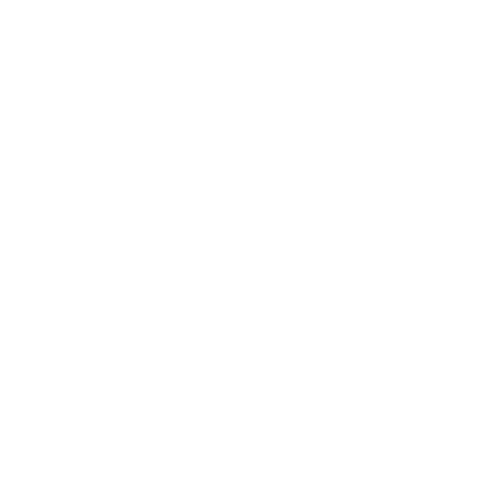

In [30]:
pca_rgb_dir = vis_dir / "pca_rgb"
pca_rgb_dir.mkdir(parents=True, exist_ok=True)

z_df_rgb = pd.DataFrame(PCA(n_components=3).fit_transform(z_df)).set_index(z_df.index)
z_df_rgb.columns = ["r", "g", "b"]
z_df_rgb_scaled = pd.DataFrame(MinMaxScaler().fit_transform(z_df_rgb)).set_index(z_df.index)
rgb_gdf = gpd.GeoDataFrame(z_df_rgb_scaled.join(hexagons[["geometry"]]), crs="EPSG:4326")
for ctp in tqdm(vc.cities_to_plot):
    fig, ax = plt.subplots(figsize=(10, 9))
    ax.set_aspect('equal')
    # ax.set_title(f"{ctp} RGB")
    ax.set_axis_off()
    gpd_rgb = rgb_gdf.loc[:, :, ctp]
    gpd_rgb.to_crs(epsg=3857).plot(ax=ax, alpha=0.7, color=gpd_rgb[[0, 1, 2]].to_numpy())
    plt.tight_layout()
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    fig.savefig(pca_rgb_dir / f"{ctp}.png", facecolor='w', dpi=100)
    plt.close()

In [ ]:
# fig = px.scatter_3d(z_df_rgb, x="r", y="g", z="b", color=df_clusters[c])
# fig.show(renderer="browser")